# CNN 
##### Classifying with FashionMNIST dataset

In [ ]:
#TODO: add str representation to plots

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

##### A) Implementing the CNN: 

###### Importing dataset:

In [3]:
# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load datasets
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

###### Setting training data

In [4]:
# Split train into train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

###### CNN

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Convolution layer 1
        self.conv1 = nn.LazyConv2d( out_channels=32, kernel_size=3, stride=1, padding=1)
        # Convolution layer 2
        self.conv2 = nn.LazyConv2d(out_channels=64, kernel_size=3, stride=1, padding=1)
        
        ## Fully connected layers using LazyLinear
        self.fc1 = nn.LazyLinear(128)
        self.fc2 = nn.LazyLinear(10)

    def __str__(self):
        return "CNN"

    def forward(self, x):

        # Layer 1: Convolution -> Activation -> Pooling
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2) # 2x2 max pooling

        # Layer 2: Convolution -> Activation -> Pooling
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2) # 2x2 max pooling

        # Flatten the tensor
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x
    

In [5]:
def training(model, n_epochs_= 5, lr=0.001):
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    num_epochs = n_epochs_
    train_losses = []
    val_accuracies = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = correct / total
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    return train_losses, val_accuracies

In [30]:
cnn = CNN()
cnn_losses, cnn_accuracy = training(cnn, n_epochs_= 10)

Epoch [1/10], Loss: 0.4687, Val Accuracy: 0.8646
Epoch [2/10], Loss: 0.2958, Val Accuracy: 0.9020
Epoch [3/10], Loss: 0.2442, Val Accuracy: 0.9107
Epoch [4/10], Loss: 0.2152, Val Accuracy: 0.9095
Epoch [5/10], Loss: 0.1890, Val Accuracy: 0.9246
Epoch [6/10], Loss: 0.1673, Val Accuracy: 0.9146
Epoch [7/10], Loss: 0.1461, Val Accuracy: 0.9257
Epoch [8/10], Loss: 0.1263, Val Accuracy: 0.9209
Epoch [9/10], Loss: 0.1093, Val Accuracy: 0.9238
Epoch [10/10], Loss: 0.0923, Val Accuracy: 0.9219


In [6]:
def plot(losses, accuracy):
    fig, ax1 = plt.subplots()

    color = 'tab:blue'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(losses, color=color, label='Training Loss')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  
    color = 'tab:red'
    ax2.set_ylabel('Validation Accuracy', color=color)  
    ax2.plot(accuracy, color=color, label='Validation Accuracy')
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  
    plt.title('Training Loss and Validation Accuracy')
    plt.show()

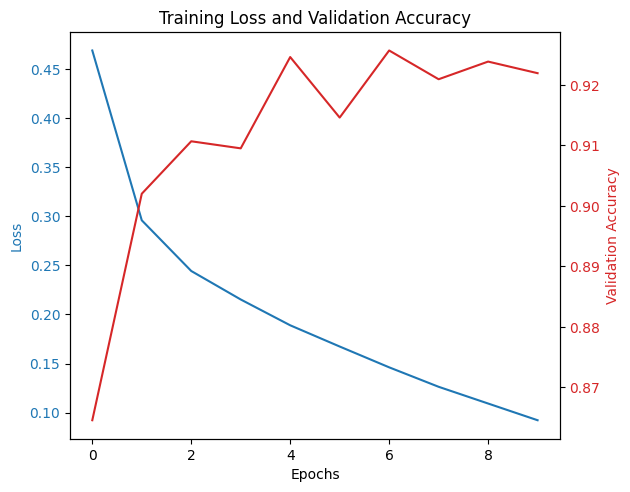

In [31]:
plot(cnn_losses, cnn_accuracy)

#### B) adding drop-out:

In [ ]:
class DropoutCNN(nn.Module):
    def __init__(self):
        super(DropoutCNN, self).__init__()

        # Convolution layer 1
        self.conv1 = nn.LazyConv2d(out_channels=32, kernel_size=3, stride=1, padding=1)
        # Convolution layer 2
        self.conv2 = nn.LazyConv2d(out_channels=64, kernel_size=3, stride=1, padding=1)
        
        ## Fully connected layers using LazyLinear
        self.fc1 = nn.LazyLinear(128)
        self.fc2 = nn.LazyLinear(10)
        
        # Dropout layers
        self.dropout1 = nn.Dropout(0.5)  # dropout probability
        self.dropout2 = nn.Dropout(0.5)

    def __str__(self):
        return "Dropout CNN"

    def forward(self, x):

        # Layer 1: Convolution -> Activation -> Pooling
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2) # 2x2 max pooling

        # Layer 2: Convolution -> Activation -> Pooling
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2) # 2x2 max pooling

        # Flatten the tensor
        x = x.view(x.size(0), -1)

        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout1(x) # Apply dropout after the first FC layer
        x = self.fc2(x)
        x = self.dropout2(x) # Apply dropout after the second FC layer

        return x   

###### Drop-out training:

In [34]:
dropoutCNN = DropoutCNN()
dropoutCNN_losses, dropoutCNN_accuracy = training(dropoutCNN, n_epochs_= 10)

Epoch [1/10], Loss: 1.3271, Val Accuracy: 0.8648
Epoch [2/10], Loss: 1.1585, Val Accuracy: 0.8876
Epoch [3/10], Loss: 1.1168, Val Accuracy: 0.8985
Epoch [4/10], Loss: 1.0973, Val Accuracy: 0.9054
Epoch [5/10], Loss: 1.0695, Val Accuracy: 0.9093
Epoch [6/10], Loss: 1.0587, Val Accuracy: 0.9096
Epoch [7/10], Loss: 1.0420, Val Accuracy: 0.9133
Epoch [8/10], Loss: 1.0355, Val Accuracy: 0.9166
Epoch [9/10], Loss: 1.0259, Val Accuracy: 0.9178
Epoch [10/10], Loss: 1.0077, Val Accuracy: 0.9194


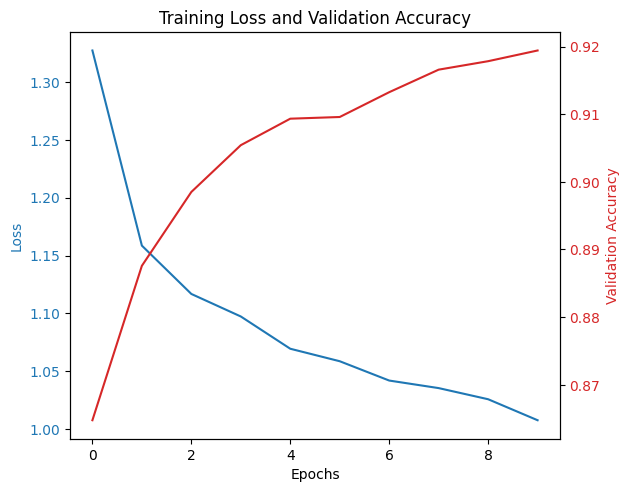

In [35]:
plot(dropoutCNN_losses, dropoutCNN_accuracy)

###### Train loss end up bigger but accuracy grows more stable. That's because, since the training has a lower "access" to neurons the NN capacity of learning decreases, but forcing each neuron to be "stronger". But evaluation uses the whole net, using all, now more generalized neurons, make it's predction is more reliable

#### C) Adding batchNorm:

###### Batch Normalization Training:

In [ ]:
class BatchNormCNN(nn.Module):
    def __init__(self):
        super(BatchNormCNN, self).__init__()

        # Convolution layer 1
        self.conv1 = nn.LazyConv2d(out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32) #there's also lazy, but output is right up there
        # Convolution layer 2
        self.conv2 = nn.LazyConv2d(out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        ## Fully connected layers using LazyLinear
        self.fc1 = nn.LazyLinear(128)
        self.fc2 = nn.LazyLinear(10)

    def __str__(self):
        return "BN CNN"

    def forward(self, x):

        # Layer 1: Convolution -> BatchNorm -> Activation -> Pooling
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2) # 2x2 max pooling

        # Layer 2: Convolution -> BatchNorm -> Activation -> Pooling
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2) # 2x2 max pooling

        # Flatten the tensor
        x = x.view(x.size(0), -1)

        # Fully connected layers 
        x = self.fc2(F.relu(self.fc1(x)))

        return x   

In [10]:
BN_cnn = BatchNormCNN()
BN_losses, BN_accuracy = training(BN_cnn, n_epochs_= 10)

Epoch [1/10], Loss: 0.3948, Val Accuracy: 0.8922
Epoch [2/10], Loss: 0.2681, Val Accuracy: 0.9047
Epoch [3/10], Loss: 0.2262, Val Accuracy: 0.9078
Epoch [4/10], Loss: 0.1968, Val Accuracy: 0.9177
Epoch [5/10], Loss: 0.1734, Val Accuracy: 0.9216
Epoch [6/10], Loss: 0.1507, Val Accuracy: 0.9150
Epoch [7/10], Loss: 0.1306, Val Accuracy: 0.9172
Epoch [8/10], Loss: 0.1174, Val Accuracy: 0.9218
Epoch [9/10], Loss: 0.1004, Val Accuracy: 0.9213
Epoch [10/10], Loss: 0.0850, Val Accuracy: 0.9236


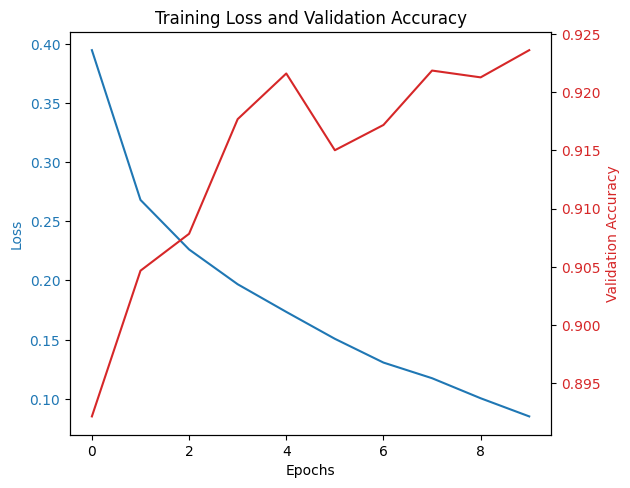

In [11]:
plot(BN_losses, BN_accuracy)

#### D) Adding residual connections:

In [ ]:
class RES_CNN(nn.Module):
    def __init__(self, num_channels):
        super(RES_CNN, self).__init__()

        # Convolution layer 1 #TODO: make layers deep so residual connections are more useful
        # TODO: maybe do separeted VGG blocks

        # Shall not change the output channels
        self.conv1 = nn.LazyConv2d(out_channels=num_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64) 
        # Convolution layer 2
        self.conv2 = nn.LazyConv2d(out_channels=num_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64) 
        
        ## Fully connected layers using LazyLinear
        self.fc1 = nn.LazyLinear(128)
        self.fc2 = nn.LazyLinear(10)

    def __str__(self):
        return "Residual CNN"

    def forward(self, x):

        # Layer 1: 
        y = self.conv1(x)
        y = self.bn1(y)  # Batch normalization
        y = F.relu(y)

        # Layer 2: 
        y = self.conv2(y)
        y = self.bn2(y)
        # Sum before ReLU

        y += x  # Residual connection
        y = F.relu(x)

        # Flatten the tensor
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x   

In [13]:
res_CNN = RES_CNN(num_channels=64)
res_CNN_losses, res_CNN_accuracy = training(res_CNN, n_epochs_= 10)

Epoch [1/10], Loss: 0.5154, Val Accuracy: 0.8477
Epoch [2/10], Loss: 0.3915, Val Accuracy: 0.8582
Epoch [3/10], Loss: 0.3545, Val Accuracy: 0.8661
Epoch [4/10], Loss: 0.3309, Val Accuracy: 0.8736
Epoch [5/10], Loss: 0.3082, Val Accuracy: 0.8690
Epoch [6/10], Loss: 0.2963, Val Accuracy: 0.8841
Epoch [7/10], Loss: 0.2796, Val Accuracy: 0.8822
Epoch [8/10], Loss: 0.2708, Val Accuracy: 0.8847
Epoch [9/10], Loss: 0.2575, Val Accuracy: 0.8839
Epoch [10/10], Loss: 0.2495, Val Accuracy: 0.8871


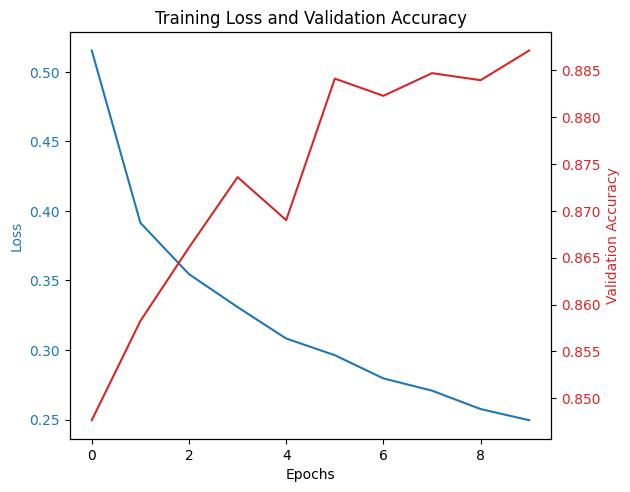

In [14]:
plot(res_CNN_losses, res_CNN_accuracy)

### Batch norm an Dropout, and finally all together

###### Batch Normalization + Dropout

In [ ]:
class BN_Dropout_CNN(nn.Module):
    def __init__(self):
        super(BN_Dropout_CNN, self).__init__()

        # Convolution layer 1
        self.conv1 = nn.LazyConv2d(out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32) #there's also lazy, but output is right up there
        # Convolution layer 2
        self.conv2 = nn.LazyConv2d(out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        ## Fully connected layers using LazyLinear
        self.fc1 = nn.LazyLinear(128)
        self.fc2 = nn.LazyLinear(10)
        
        # Dropout layers
        self.dropout1 = nn.Dropout(0.5)  # dropout probability
        self.dropout2 = nn.Dropout(0.5)

    def __str__(self):
        return "BN + Drop CNN"

    def forward(self, x):

        # Layer 1: Convolution -> BatchNorm -> Activation -> Pooling
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2) # 2x2 max pooling

        # Layer 2: Convolution -> BatchNorm -> Activation -> Pooling
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2) # 2x2 max pooling

        # Flatten the tensor
        x = x.view(x.size(0), -1)

        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout1(x) # Apply dropout after the first FC layer
        x = self.fc2(x)
        x = self.dropout2(x) # Apply dropout after the second FC layer

        return x   

In [ ]:
BN_cnn = BN_Dropout_CNN()
BN_Dropout_cnn_losses, BN_Dropout_cnn_accuracy = training(BN_cnn, n_epochs_= 10)

Epoch [1/10], Loss: 1.3843, Val Accuracy: 0.8608
Epoch [2/10], Loss: 1.2403, Val Accuracy: 0.8825
Epoch [3/10], Loss: 1.1937, Val Accuracy: 0.8897
Epoch [4/10], Loss: 1.1646, Val Accuracy: 0.8961
Epoch [5/10], Loss: 1.1590, Val Accuracy: 0.9046
Epoch [6/10], Loss: 1.1348, Val Accuracy: 0.9048
Epoch [7/10], Loss: 1.1244, Val Accuracy: 0.9050
Epoch [8/10], Loss: 1.1118, Val Accuracy: 0.9083
Epoch [9/10], Loss: 1.0976, Val Accuracy: 0.9099
Epoch [10/10], Loss: 1.0982, Val Accuracy: 0.9126


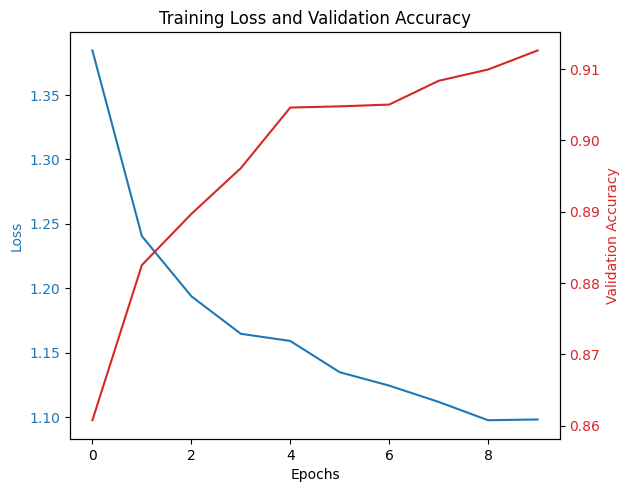

In [ ]:
plot(BN_Dropout_cnn_losses, BN_Dropout_cnn_accuracy)

###### All together

In [ ]:
class AllCNN(nn.Module):
    def __init__(self, num_channels):
        super(AllCNN, self).__init__()

        # Convolution layer 1 #TODO: make layers deep so residual connections are more useful
        # TODO: maybe do separeted VGG blocks

        # Shall not change the output channels
        self.conv1 = nn.LazyConv2d(out_channels=num_channels, kernel_size=3, stride=1, padding=1)
        # Convolution layer 2
        self.conv2 = nn.LazyConv2d(out_channels=num_channels, kernel_size=3, stride=1, padding=1)
        
        ## Fully connected layers using LazyLinear
        self.fc1 = nn.LazyLinear(128)
        self.fc2 = nn.LazyLinear(10)

        # Dropout layers
        self.dropout1 = nn.Dropout(0.5)  # dropout probability
        self.dropout2 = nn.Dropout(0.5)

    def __str__(self):
        return "All CNN"

    def forward(self, x):

        # Layer 1: 
        y = self.conv1(x)
        y = F.relu(y)

        # Layer 2: 
        y = self.conv2(y)
        # Sum before ReLU

        y += x  # Residual connection
        y = F.relu(x)

        # Flatten the tensor
        x = x.view(x.size(0), -1)

        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout1(x) # Apply dropout after the first FC layer
        x = self.fc2(x)
        x = self.dropout2(x) # Apply dropout after the second FC layer

        return x   

In [17]:
together = AllCNN(num_channels=64)
together_losses, together_accuracy = training(together, n_epochs_= 10)

Epoch [1/10], Loss: 1.3905, Val Accuracy: 0.8077
Epoch [2/10], Loss: 1.2735, Val Accuracy: 0.8333
Epoch [3/10], Loss: 1.2502, Val Accuracy: 0.8452
Epoch [4/10], Loss: 1.2410, Val Accuracy: 0.8438
Epoch [5/10], Loss: 1.2184, Val Accuracy: 0.8482
Epoch [6/10], Loss: 1.2080, Val Accuracy: 0.8546
Epoch [7/10], Loss: 1.2039, Val Accuracy: 0.8548
Epoch [8/10], Loss: 1.2050, Val Accuracy: 0.8642
Epoch [9/10], Loss: 1.1910, Val Accuracy: 0.8576
Epoch [10/10], Loss: 1.1957, Val Accuracy: 0.8615


In [ ]:
plot(together_losses, together_accuracy)

### Comparing the results of having residual connections at deep networks

##### Creating a deep CNN:

In [ ]:
class DeepCNN(nn.Module):
    def __init__(self, convs = 5):
        super(DeepCNN, self).__init__()

        layers = []
        for _ in range(convs):
            layers.append(nn.LazyConv2d(out_channels=32, kernel_size=3, stride=1, padding=1))
            layers.append(nn.BatchNorm2d(32))
            layers.append(nn.ReLU())
        self.convs = nn.Sequential(*layers)
        
        ## Fully connected layers using LazyLinear
        self.fc1 = nn.LazyLinear(128)
        self.fc2 = nn.LazyLinear(10)

        # Dropout layers
        self.dropout1 = nn.Dropout(0.5) 
        self.dropout2 = nn.Dropout(0.5)

    def __str__(self):
        return "Deep CNN"

    def forward(self, x):

        x = self.convs(x)

        # Flatten the tensor
        x = x.view(x.size(0), -1)

        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout1(x) 
        x = self.fc2(x)
        x = self.dropout2(x) 

        return x   

In [64]:
deep_cnn = DeepCNN(convs=4)
deep_cnn_losses, deep_cnn_accuracy = training(deep_cnn, n_epochs_= 10)

Epoch [1/10], Loss: 1.5527, Val Accuracy: 0.8216
Epoch [2/10], Loss: 1.3839, Val Accuracy: 0.8430
Epoch [3/10], Loss: 1.3260, Val Accuracy: 0.8690
Epoch [4/10], Loss: 1.2894, Val Accuracy: 0.8927
Epoch [5/10], Loss: 1.2612, Val Accuracy: 0.8957
Epoch [6/10], Loss: 1.2331, Val Accuracy: 0.9062
Epoch [7/10], Loss: 1.2129, Val Accuracy: 0.9115
Epoch [8/10], Loss: 1.1946, Val Accuracy: 0.9131
Epoch [9/10], Loss: 1.1716, Val Accuracy: 0.9155
Epoch [10/10], Loss: 1.1632, Val Accuracy: 0.9213


###### took a while

##### And a Deep CNN with residual connections:

In [61]:
class ResDeep(nn.Module):  #without max pooling
    def __init__(self, convs = 7):
        super(ResDeep, self).__init__()

        layers = []
        for _ in range(convs -1):
            layers.append(nn.LazyConv2d(out_channels=32, kernel_size=3, stride=1, padding=1))
            layers.append(nn.BatchNorm2d(32))
            layers.append(nn.ReLU())
        layers.append(nn.LazyConv2d(out_channels=32, kernel_size=3, stride=1, padding=1))
        layers.append(nn.BatchNorm2d(32))
        self.convs = nn.Sequential(*layers)

        # Residual connection with 1x1 convolution since input is 1 and output is 32
        self.residual_connection = nn.LazyConv2d(out_channels=32, kernel_size=1, stride=1, padding=0)
        
        ## Fully connected layers using LazyLinear
        self.fc1 = nn.LazyLinear(128)
        self.fc2 = nn.LazyLinear(10)

        # Dropout layers
        self.dropout1 = nn.Dropout(0.5) 
        self.dropout2 = nn.Dropout(0.5)

    def __str__(self):
        return "Residual Deep CNN"

    def forward(self, x):
        residual = self.residual_connection(x)

        x = self.convs(x) + residual  
        x = F.relu(x)

        # Flatten the tensor
        x = x.view(x.size(0), -1)

        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout1(x) 
        x = self.fc2(x)
        x = self.dropout2(x) 

        return x   

In [65]:
resdeep= ResDeep(convs=4)
Rd_losses, Rd_accuracy = training(resdeep, n_epochs_= 10) 

Epoch [1/10], Loss: 1.5353, Val Accuracy: 0.8457
Epoch [2/10], Loss: 1.3538, Val Accuracy: 0.8754
Epoch [3/10], Loss: 1.3020, Val Accuracy: 0.8835
Epoch [4/10], Loss: 1.2614, Val Accuracy: 0.8983
Epoch [5/10], Loss: 1.2338, Val Accuracy: 0.8972
Epoch [6/10], Loss: 1.1908, Val Accuracy: 0.9114
Epoch [7/10], Loss: 1.1425, Val Accuracy: 0.9143
Epoch [8/10], Loss: 1.1178, Val Accuracy: 0.9200
Epoch [9/10], Loss: 1.1097, Val Accuracy: 0.9181
Epoch [10/10], Loss: 1.0909, Val Accuracy: 0.9254


###### Loss decreases way faster, as the residual helps error propagate

##### Ploting both together:

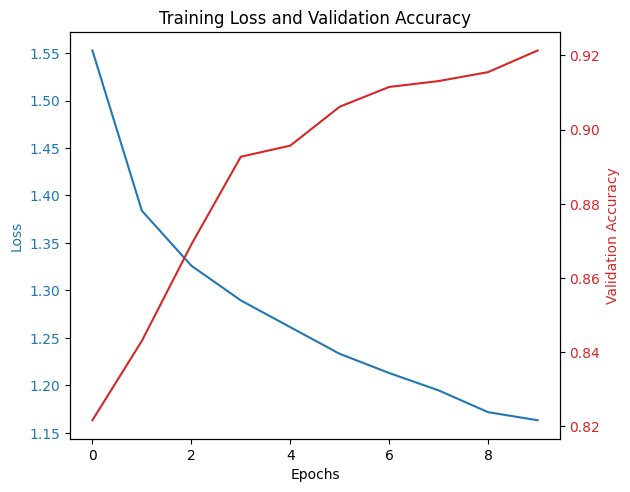

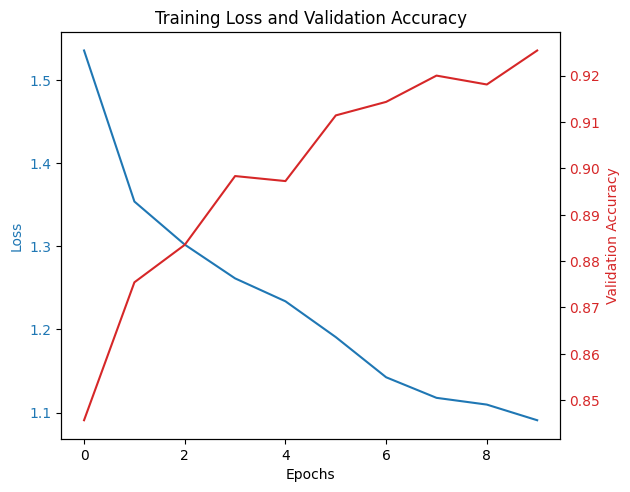

In [66]:
plot(deep_cnn_losses, deep_cnn_accuracy)
plot(Rd_losses, Rd_accuracy)